## Data Preprocessing and Feature Engineering

In [ ]:
# Importing needed libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform

from sklearn.ensemble import IsolationForest
from itertools import zip_longest

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import ADASYN
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import ttest_ind

In [2]:
# Reading the raw data 
file_path = "../data/raw/data.csv"
df = pd.read_csv(file_path)

### Displaying The First Few Rows, Dimensions, and Column Names of The Dataset

In [3]:
# Looking at the raw data
print(df.head())

# Shape of data
print(df.shape)

#
print(df.columns.tolist())

   Bankrupt?   ROA(C) before interest and depreciation before interest   
0          1                                           0.370594         \
1          1                                           0.464291          
2          1                                           0.426071          
3          1                                           0.399844          
4          1                                           0.465022          

    ROA(A) before interest and % after tax   
0                                 0.424389  \
1                                 0.538214   
2                                 0.499019   
3                                 0.451265   
4                                 0.538432   

    ROA(B) before interest and depreciation after tax   
0                                           0.405750   \
1                                           0.516730    
2                                           0.472295    
3                                           0.4577

### Missing Values

In [4]:
# Providing detailed metadata about the dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 96 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   Bankrupt?                                                 6819 non-null   int64  
 1    ROA(C) before interest and depreciation before interest  6819 non-null   float64
 2    ROA(A) before interest and % after tax                   6819 non-null   float64
 3    ROA(B) before interest and depreciation after tax        6819 non-null   float64
 4    Operating Gross Margin                                   6819 non-null   float64
 5    Realized Sales Gross Margin                              6819 non-null   float64
 6    Operating Profit Rate                                    6819 non-null   float64
 7    Pre-tax net Interest Rate                                6819 non-null   float64
 8    After-tax net Int

All the feature are non-null. There is no missing values.
93 variables are continuous. Bandrupt, our response, is categorical with two classes. We have two other categorical variables. 

In [5]:
# Defining Predictors and target

predictors =df.drop(columns=['Bankrupt?'])
target = df['Bankrupt?']

In [6]:
# Simplifying columns name to Xi

predictors.columns = [f"X{i+1}" for i in range(predictors.shape[1])]

In [18]:
# Variables name corresponding to the Xi labels

pdf=df.drop(columns=['Bankrupt?'])

list1 = pdf.columns.tolist()
list2 = [f"X{i+1}" for i in range(pdf.shape[1])]

for item1, item2 in zip_longest(list1, list2, fillvalue="N/A"):
    print(f"{item1:<10}{item2:<10}")

 ROA(C) before interest and depreciation before interestX1        
 ROA(A) before interest and % after taxX2        
 ROA(B) before interest and depreciation after taxX3        
 Operating Gross MarginX4        
 Realized Sales Gross MarginX5        
 Operating Profit RateX6        
 Pre-tax net Interest RateX7        
 After-tax net Interest RateX8        
 Non-industry income and expenditure/revenueX9        
 Continuous interest rate (after tax)X10       
 Operating Expense RateX11       
 Research and development expense rateX12       
 Cash flow rateX13       
 Interest-bearing debt interest rateX14       
 Tax rate (A)X15       
 Net Value Per Share (B)X16       
 Net Value Per Share (A)X17       
 Net Value Per Share (C)X18       
 Persistent EPS in the Last Four SeasonsX19       
 Cash Flow Per ShareX20       
 Revenue Per Share (Yuan ¥)X21       
 Operating Profit Per Share (Yuan ¥)X22       
 Per Share Net profit before tax (Yuan ¥)X23       
 Realized Sales Gross Profit Grow

### Outlier Detection 

Descriptive and exploratory data analyses illustrate the presence of outliers in each variable. Below, we demonstrate that there are extreme values which cannot be ignored and similar values are observed in financial data.

#### Isolation Forest model

In [8]:
# Fit the Isolation Forest model for Outlier Detection

data=predictors

iso_forest = IsolationForest(contamination=0.05, random_state=42)
outlier_labels = iso_forest.fit_predict(data.select_dtypes(include=['float']))

# Add the outlier labels to the dataset
data['Outlier'] = outlier_labels
outliers = data[data['Outlier'] == -1]
print("Outliers detected by Isolation Forest:")
print(outliers)

c:\ProgramData\Anaconda3\envs\dsi_participant\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Outliers detected by Isolation Forest:
            X1        X2        X3        X4        X5        X6        X7   
56    0.066933  0.057185  0.054821  0.601861  0.601861  0.998825  0.796779  \
379   0.453956  0.516082  0.501740  0.665151  0.665151  0.996295  0.776710   
427   0.311315  0.279655  0.360887  0.598293  0.598293  0.998511  0.796186   
448   0.364842  0.318415  0.393115  0.494249  0.494249  0.996804  0.789248   
527   0.392385  0.432621  0.451470  0.555939  0.555939  0.998291  0.796273   
...        ...       ...       ...       ...       ...       ...       ...   
6645  0.556184  0.612843  0.600460  0.597025  0.597025  0.998998  0.797488   
6700  0.294252  0.353195  0.324268  0.621507  0.621507  0.998777  0.796607   
6731  0.507239  0.572830  0.559077  0.596225  0.596225  0.998978  0.797430   
6753  0.584849  0.652584  0.637936  0.621780  0.621780  0.999208  0.797689   
6818  0.493053  0.570105  0.549548  0.627409  0.627409  0.998080  0.801987   

            X8        X9

Isolation Forest isolates data points by recursively splitting data using random decision trees. Normal points require more splits to be isolated, as they cluster together. Outliers are isolated quickly because they are far from other points. The algorithm is Useful in detecting anomalies in datasets with continuous features. Handles high-dimensional data and is robust to noise.

            X1        X2        X3        X4        X5        X6        X7   
0     0.370594  0.424389  0.405750  0.601457  0.601457  0.998969  0.796887  \
1     0.464291  0.538214  0.516730  0.610235  0.610235  0.998946  0.797380   
2     0.426071  0.499019  0.472295  0.601450  0.601364  0.998857  0.796403   
3     0.399844  0.451265  0.457733  0.583541  0.583541  0.998700  0.796967   
4     0.465022  0.538432  0.522298  0.598783  0.598783  0.998973  0.797366   
...        ...       ...       ...       ...       ...       ...       ...   
6814  0.493687  0.539468  0.543230  0.604455  0.604462  0.998992  0.797409   
6815  0.475162  0.538269  0.524172  0.598308  0.598308  0.998992  0.797414   
6816  0.472725  0.533744  0.520638  0.610444  0.610213  0.998984  0.797401   
6817  0.506264  0.559911  0.554045  0.607850  0.607850  0.999074  0.797500   
6818  0.493053  0.570105  0.549548  0.627409  0.627409  0.998080  0.801987   

            X8        X9       X10  ...       X88       X89    

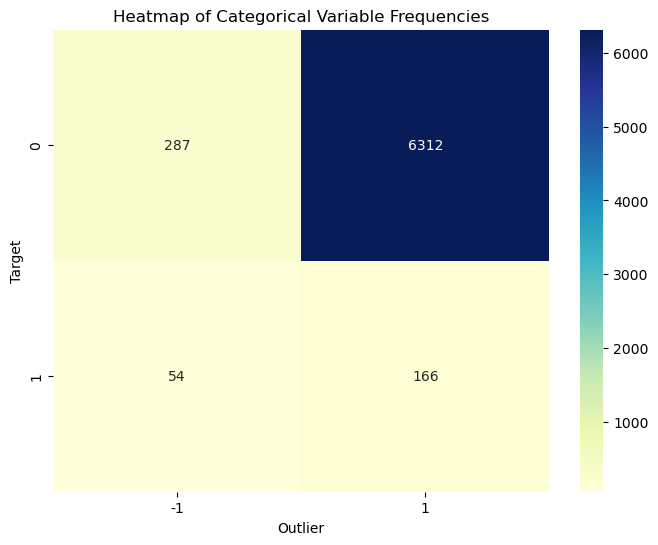

In [ ]:
# Combine predictors with Outlier label and target

combined_data = data.copy()
combined_data['Target'] = target

print(combined_data)

# Create a contingency table

contingency_table = pd.crosstab(combined_data['Target'], combined_data['Outlier'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="YlGnBu")
plt.title('Heatmap of Categorical Variable Frequencies')
plt.xlabel('Outlier')
plt.ylabel('Target')
plt.show()


As shown in the plot, nearly 30% of the data in the bankrupt group are labeled as outliers, indicating that these extreme values are associated with bankruptcy.

Frequency of Outliers per Variable:
     Outlier Frequency
X1                 391
X2                 561
X3                 432
X4                 320
X5                 318
..                 ...
X90                571
X91                404
X92               1503
X93               1421
X95                549

[93 rows x 1 columns]


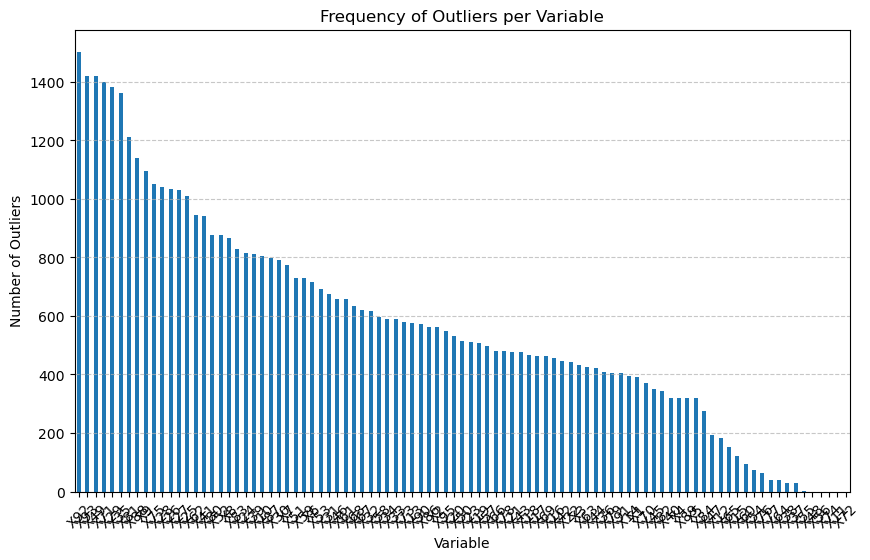

In [10]:
# Quantile method to illustrate the frequency of outliers of the predictors
# Function to calculate the frequency of outliers using the IQR method

def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)].shape[0]

# Apply the function to all numerical columns
outlier_frequencies = {}
for column in data.select_dtypes(include=['float']).columns:
    outlier_frequencies[column] = detect_outliers_iqr(data, column)

# Convert to a DataFrame for better readability
outlier_frequencies_df = pd.DataFrame.from_dict(outlier_frequencies, orient='index', columns=['Outlier Frequency'])

# Display the results
print("Frequency of Outliers per Variable:")
print(outlier_frequencies_df)

# Visualize the outlier frequencies
outlier_frequencies_df.sort_values(by='Outlier Frequency', ascending=False).plot(kind='bar', figsize=(10, 6), legend=False)
plt.title('Frequency of Outliers per Variable')
plt.xlabel('Variable')
plt.ylabel('Number of Outliers')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### Identifing and Removing Variables with Constant Values

In [12]:
# Calculate the standard deviation of each column
std_deviation = predictors.std()

# Identify columns with std = 0
zero_std_columns = std_deviation[std_deviation == 0].index

# Drop these columns from the DataFrame
predictors = predictors.drop(columns=zero_std_columns)

# Print the remaining columns
print(f"Columns with non-zero standard deviation: {predictors.columns.tolist()}")
print(predictors.shape)

Columns with non-zero standard deviation: ['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X95', 'Outlier']
(6819, 95)


### Detect Collinearity Among Predictors
#### Correlation Matrix  

In [13]:
# Calculate the correlation matrix
correlation_matrix = predictors.corr()
print(correlation_matrix)

               X1        X2        X3        X4        X5        X6        X7   
X1       1.000000  0.940124  0.986849  0.334719  0.332755  0.035725  0.053419  \
X2       0.940124  1.000000  0.955741  0.326969  0.324956  0.032053  0.053518   
X3       0.986849  0.955741  1.000000  0.333749  0.331755  0.035212  0.053726   
X4       0.334719  0.326969  0.333749  1.000000  0.999518  0.005745  0.032493   
X5       0.332755  0.324956  0.331755  0.999518  1.000000  0.005610  0.032232   
...           ...       ...       ...       ...       ...       ...       ...   
X91     -0.143629 -0.141039 -0.142838 -0.085434 -0.085407  0.001541 -0.004043   
X92     -0.016575 -0.011515 -0.014663 -0.011806 -0.011268  0.000935  0.000855   
X93      0.010573  0.013372  0.011473 -0.001167 -0.001158  0.000393  0.000984   
X95      0.052416  0.057887  0.056430  0.120029  0.120196 -0.017071 -0.014559   
Outlier  0.129093  0.168038  0.151356  0.016069  0.015612  0.087968  0.088615   

               X8        X9

#### Identifying Highly Correlated Predictor Pairs Using a Threshold

In [18]:
# Define a correlation threshold
threshold = 0.85

# Find pairs of variables with correlation above the threshold
high_corr_pairs = []

# Iterate through the correlation matrix
for i in range(correlation_matrix.shape[0]):
    for j in range(i + 1, correlation_matrix.shape[1]):  # Avoid self-correlation and duplicate pairs
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            high_corr_pairs.append((correlation_matrix.index[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

# Convert to a DataFrame for better readability
high_corr_df = pd.DataFrame(high_corr_pairs, columns=["Feature_1", "Feature_2", "Correlation"])

# Display the high correlation pairs
print("Highly Correlated Pairs:")
print(high_corr_df)


Highly Correlated Pairs:
   Feature_1 Feature_2  Correlation
0         X1        X2     0.940124
1         X1        X3     0.986849
2         X1       X86     0.887670
3         X2        X3     0.955741
4         X2       X86     0.961552
5         X3       X86     0.912040
6         X4        X5     0.999518
7         X4       X89     1.000000
8         X5       X89     0.999518
9         X6        X7     0.916448
10        X6        X8     0.862191
11        X6       X10     0.915544
12        X7        X8     0.986379
13        X7       X10     0.993617
14        X8       X10     0.984452
15       X13       X61     0.880562
16       X16       X17     0.999342
17       X16       X18     0.999179
18       X17       X18     0.999837
19       X19       X22     0.876769
20       X19       X23     0.955591
21       X19       X42     0.873641
22       X19       X43     0.959461
23       X22       X23     0.861813
24       X22       X42     0.998696
25       X22       X43     0.886157
26 

After identifying collinear pairs, decide whether to:

1. Remove one of the variables in the pair.
2. Combine them using dimensionality reduction (e.g., Principal Component Analysis).

#### Removing completely correlated variables
##### Removing the variables with the correlation coeficient equals to one.

In [15]:
#Removing completely correlated variables

Removed_predictors = predictors.drop(columns=['X77','X78','X37','X4'])

##### Principal Component Analysis

In [20]:
#Principal Component Analysis

data= Removed_predictors.drop(columns=['Outlier'])

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Apply PCA
pca = PCA(n_components=0.95)  # Keep 95% of the variance
pca_data = pca.fit_transform(scaled_data)

# Create a DataFrame for PCA results
pca_df = pd.DataFrame(pca_data, columns=[f"PC{i+1}" for i in range(pca_data.shape[1])])

# Explain Variance Ratio
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

print("Explained Variance Ratio for Each Component:")
print(explained_variance)
print("\nCumulative Explained Variance:")
print(cumulative_variance)

# Add PCA components back to the original dataset
data_pca = pd.concat([data.reset_index(drop=True), pca_df], axis=1)

# Save or display the PCA results
print("DataFrame after PCA:")
pca_df.head()


Explained Variance Ratio for Each Component:
[0.13410695 0.0645518  0.04752262 0.04522877 0.04335571 0.03261283
 0.03105628 0.0295987  0.02429113 0.02211259 0.02101825 0.0201088
 0.01680435 0.01648626 0.01623645 0.0157156  0.01506311 0.01420837
 0.01360025 0.01321776 0.01293621 0.0124447  0.01180121 0.01157443
 0.01154401 0.01131631 0.01122314 0.01118571 0.01115853 0.01092053
 0.01079328 0.01064477 0.01063222 0.0104681  0.01026448 0.01012225
 0.01006881 0.00983063 0.00953186 0.0093829  0.00919818 0.00912158
 0.0088625  0.00881565 0.00823282 0.00787688 0.00756894 0.00721293
 0.0062865  0.00622948 0.00597909 0.00594218 0.00534455]

Cumulative Explained Variance:
[0.13410695 0.19865875 0.24618137 0.29141014 0.33476585 0.36737867
 0.39843495 0.42803365 0.45232479 0.47443737 0.49545562 0.51556442
 0.53236877 0.54885503 0.56509148 0.58080709 0.59587019 0.61007857
 0.62367881 0.63689657 0.64983279 0.66227748 0.67407869 0.68565313
 0.69719714 0.70851345 0.71973658 0.73092229 0.74208082 0.75300

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53
0,-7.103553,0.701326,0.690654,0.621796,-0.768014,1.089171,-0.354233,-0.351208,-1.739177,1.700831,...,-0.193031,-1.399707,0.344207,0.145730,0.192354,-0.310633,-0.245096,-0.314524,0.677883,-0.040918
1,-2.573896,-0.677168,2.232905,0.672566,-1.714187,0.064308,-0.396601,-0.347495,-0.753522,0.132789,...,-0.060277,-0.261255,0.488831,0.018781,0.190311,0.360591,-0.139801,-0.189303,0.814913,0.425375
2,-4.039121,-0.295945,0.214322,0.052009,-0.335778,-0.694654,0.073777,0.271234,-0.175184,1.013394,...,0.735391,1.028007,0.288400,-0.827024,0.660844,0.770025,-0.068128,0.412949,0.514335,0.731801
3,-5.676429,-0.890374,1.877745,0.715350,-1.644265,1.148120,-0.777757,-0.553197,0.211164,0.579703,...,-0.472362,1.546004,0.814564,-0.818686,-0.810140,-0.011105,0.678353,0.871670,-0.394857,0.798656
4,-2.373837,0.038625,-0.194126,0.985623,-0.972471,0.651210,-0.664947,-0.459284,0.588565,-0.369618,...,-0.179852,-0.538154,-1.143264,0.094734,0.528516,-0.282007,-0.415693,0.013646,-0.658998,-0.351253


### Addressing Class Imbalance Through Data Balancing Techniques

The target variable in the dataset is imbalanced, meaning one class has significantly fewer examples compared to the other(s). This imbalance can lead to biased model predictions favoring the majority class.

Why It Matters: Machine learning models tend to perform poorly on the minority class in such scenarios, resulting in low recall, precision, or F1-scores for the minority class.

#### Synthetic Data Generation
Applied SMOTE and ADASYN to generate synthetic data points for the minority class. These synthetic examples are based on interpolation between existing data points, reducing overfitting risks associated with simple duplication.

Note that do not apply SMOTE on the test set. Balancing is only for training data to prevent data leakage.

In [ ]:
#!pip install imbalanced-learn

#### SMOTE
Synthetic Minority Oversampling Technique

In [22]:
X = Removed_predictors
y = target

# Step 1: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Display the results
print("Original Class Distribution in Training Data:")
print(pd.Series(y_train).value_counts())

print("\nBalanced Class Distribution in Training Data:")
print(pd.Series(y_train_balanced).value_counts())

print("\nShape of Balanced Data:")
print(f"Features: {X_train_balanced.shape}, Target: {y_train_balanced.shape}")

Original Class Distribution in Training Data:
Bankrupt?
0    5279
1     176
Name: count, dtype: int64

Balanced Class Distribution in Training Data:
Bankrupt?
0    5279
1    5279
Name: count, dtype: int64

Shape of Balanced Data:
Features: (10558, 91), Target: (10558,)


#### ADASYN
Adaptive Synthetic Sampling: good for high dimensional data (many features)

In [25]:
adasyn = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = adasyn.fit_resample(X_train, y_train)

# Display the results
print("Original Class Distribution in Training Data:")
print(pd.Series(y_train).value_counts())

print("\nBalanced Class Distribution in Training Data:")
print(pd.Series(y_train_balanced).value_counts())

print("\nShape of Balanced Data:")
print(f"Features: {X_train_balanced.shape}, Target: {y_train_balanced.shape}")

Original Class Distribution in Training Data:
Bankrupt?
0    5279
1     176
Name: count, dtype: int64

Balanced Class Distribution in Training Data:
Bankrupt?
1    5305
0    5279
Name: count, dtype: int64

Shape of Balanced Data:
Features: (10584, 91), Target: (10584,)


### Identifying Unimportant Features (Significant Variables) Using T-Test
The t-test is used to determine whether the mean of a feature differs significantly between the two target classes (class 0 and class 1). This helps identify features that are statistically important for distinguishing between the classes.

In [30]:
# Combine predictors and target

predictors = Removed_predictors
combined_df = predictors.copy()
combined_df['Target'] = target

data=combined_df
data.select_dtypes(include=['float']).columns.shape
    

(89,)

In [32]:
# t-test for difference between classes

X_balanced, y_balanced = smote.fit_resample(Removed_predictors, target)

# Combine predictors and target
data = X_balanced.copy()
data['Target'] = y_balanced

# T-Test Function
def perform_t_tests(df, target, alpha=0.05):
    numerical_features = df.select_dtypes(include=['float', 'int']).columns
    t_test_results = []

    for feature in numerical_features:
        if feature == target:  # Skip the target variable itself
            continue
        
        # Separate data into two groups based on target variable
        group1 = df[df[target] == 0][feature]
        group2 = df[df[target] == 1][feature]
        
        # Perform t-test
        t_stat, p_value = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test
        
        # Store results
        t_test_results.append({
            'Feature': feature,
            'T-Statistic': t_stat,
            'P-Value': p_value,
            'Significant': p_value < alpha  # True if p-value is below alpha
        })

    return pd.DataFrame(t_test_results)

# Perform t-tests
t_test_results = perform_t_tests(data, target='Target')
print(t_test_results)

    Feature  T-Statistic        P-Value  Significant
0        X1    81.831702   0.000000e+00         True
1        X2    78.329163   0.000000e+00         True
2        X3    80.618068   0.000000e+00         True
3        X5    39.430899   0.000000e+00         True
4        X6     0.137026   8.910148e-01        False
..      ...          ...            ...          ...
86      X91   -21.098960   8.706245e-96         True
87      X92    -2.655203   7.936728e-03         True
88      X93     0.802506   4.222818e-01        False
89      X95    31.991855  9.238810e-216         True
90  Outlier    41.934986   0.000000e+00         True

[91 rows x 4 columns]


In [63]:
# Identify non-significant variables (False significants)
non_significant_vars = t_test_results[t_test_results['Significant'] == False]['Feature'].tolist()

# Display the results
print("Non-Significant Variables (False Significants):")
print(non_significant_vars)


Non-Significant Variables (False Significants):
['X6', 'X24', 'X33', 'X39', 'X53', 'X58', 'X62', 'X63', 'X73', 'X75', 'X85', 'X93']


### Conclusion

Based on a rigorous feature selection process, we identified 78 predictors as more important than others for our analysis. This decision was guided by the following steps:

T-Test Results: We performed t-tests to assess the significance of each predictor in distinguishing between the target classes.
Features with statistically significant differences (p-value < 0.05) were retained.

Removal of Highly Correlated Variables: Using a correlation threshold of 0.85, we identified and removed predictors with high collinearity to minimize redundancy and potential multicollinearity issues.

Elimination of Constant Variables: Predictors with constant values were excluded as they provide no variance or discriminatory power.

This is the final list of variables that were selected and entered into the predictive model:

In [34]:
list1 = pdf.columns.tolist()
list2 = [f"X{i+1}" for i in range(pdf.shape[1])]

# Create a mapping from Xi labels to original variable names
xi_to_names = dict(zip(list2, list1))

# List of variables to search
search_label = ["X4", "X6", "X24", "X33", "X37", "X39", "X53", "X58", "X62", "X63", "X73", "X75", "X77", "X78","X85","X93","X94"]

# Find and print the variable names for each Xi
for label in search_label:
    if label in xi_to_names:
        print(f"{label} corresponds to: {xi_to_names[label]}")
    else:
        print(f"{label} not found in the mapping.")


X4 corresponds to:  Operating Gross Margin
X6 corresponds to:  Operating Profit Rate
X24 corresponds to:  Realized Sales Gross Profit Growth Rate
X33 corresponds to:  Current Ratio
X37 corresponds to:  Debt ratio %
X39 corresponds to:  Long-term fund suitability ratio (A)
X53 corresponds to:  Allocation rate per person
X58 corresponds to:  Quick Assets/Current Liability
X62 corresponds to:  Inventory/Working Capital
X63 corresponds to:  Inventory/Current Liability
X73 corresponds to:  Working capitcal Turnover Rate
X75 corresponds to:  Cash Flow to Sales
X77 corresponds to:  Current Liability to Liability
X78 corresponds to:  Current Liability to Equity
X85 corresponds to:  Liability-Assets Flag
X93 corresponds to:  Interest Coverage Ratio (Interest expense to EBIT)
X94 corresponds to:  Net Income Flag


Note that we also evaluated the models using all variables (including both important and unimportant ones) as well as principal components. However, the models' performance did not change significantly. To streamline the report, we have omitted detailed results for these experiments from this chapter.